## JWST - NIRCam - Level 3 TSO Pipeline
This pipeline was commissioned to take input from the Level 2 pipeline -- having been processed through the NIRCam `ncdhas` pipeline -- and now being further processed through from a stack of images into a time series

**NEW METHOD**

1. Develop a single routine that inputs 
    1. String (fits file name) or array (loaded fits file)
    2. The expected location of the star (center of frame is default)
    3. Subframe size (for better center fitting)
    4. List of aperture radii (or a float for a single aperture radii)
2. This routine will load a single fits file or list of fits files (one at a time; recursive?)
3. For each single, or recursively for a list of fits files, 
    1. load the data.
    2. Computer the time element
    3. subtract the background (store background level)
    4. isolate the star into a subframe
    5. Cross-correlate a Gaussian (or JWST psf) with the image to find predicted center (store CC center)
    6. Gaussian fit to subframe, starting at CC center (store GS center, width, amplitude)
    7. Perform apeture photometry with each radius given at the beginning (store aperture radii as a function of radius)

This routine ensures that the user can manipulate the inputs as needed. Users can either send a single fits array, a set of fits array, a single string with the location of a fits file, or a list of strings with the location of several fits files.

The result will be a 'DataFrame' of the same depth as the input structure, containing (labeled as keys) the 
- 'sky background'
- 'cross correlation center'
- 'gaussian center'
- 'gaussian width'
- 'gaussian ampitude'
- 'aperture photometry dictionary' or 'aperture photometry dataframe'
    - the keys to the aperture photometry dictionary or data frame will be the float values of the aperture radii
- 'time' (in days?)

**OLD METHOD - for Posterity and External Comparison**
1.  Input data from file directory from user
2.  Access that file directory and grab all file names
     -- possible include a data file 
3.  Sequentially open all fits file in that directory (or from the data file)
4.  During the opening process, store the data frame(s) necessary for production of time series
5.  Remove the original data from RAM (too much space)
6.  Subtract median background
7.  Cross-Correlated Gaussian with center of image
8.  Fit a Gaussian to center of image, starting from Cross-Correlation solution
9.  Integrate (using 'exact') the aperture photometry
10. Store aperture photometry, gaussian centers, cross-correlation centers, gaussian widths, gaussian heights

Load All Necessary Libraries and Functions
---

    `pylab`      : combination of array manipulation and plotting functions
    `matplotlib` : specialized plotting functions
    `numpy`      : array more manipulation functions
    `pandas`     : dataframe -- more advanced array / table -- functions
    `photutils`  : astropy associated package for aperture photometry
    `astropy`    : `modeling` : access linear and gaussian functions with astropy formatting
                   `fitting`  : access to astropy fitting routines
    `glob`       : grab list of files in directory

    -- Not Used Yet --
    `astroML`    : better histogram function for plotting
    `sklearn`    : `externals`: imports operating system (storage) level function (i.e. joblib)
    `statsmodels`: `robust`   : robust statistical modeling packages; `scale.mad` == median average distance
    `sys`        : python-os level functions (i.e. path)
    `time`       : compute and convert current timestamps from python / os

In [1]:
# Matplotlib for Plotting
%matplotlib inline
from pylab              import gcf, sort, linspace, indices, std, empty, concatenate, pi, sqrt, ones, diag, inf
from pylab              import rcParams, array, get_current_fig_manager, twinx, figure, subplots_adjust

from matplotlib.ticker  import MaxNLocator
from matplotlib         import style
from matplotlib         import pyplot as plt

# Numpy & Pandas for Array and DataFrame Manipulation
from numpy              import min, max, median, mean, zeros, empty
from numpy              import ones, where, arange, indices
from pandas             import DataFrame, read_csv, scatter_matrix

# Astropy for Aperture Photometry and Fits read/write
from photutils          import CircularAperture, aperture_photometry
# from astroML.plotting   import hist
from astropy.modeling   import models, fitting
from astropy.io         import fits

# Built in Libraries for directory
from glob               import glob

# Adam Ginsburg
from image_registration import cross_correlation_shifts

# Data Storage from Sci-kits
# from sklearn.externals import joblib

# Style Components
# from seaborn            import *

# from socket             import gethostname
# from statsmodels.robust import scale
# from sys                import exit, stdout
# from time               import time

style.use('fivethirtyeight')

This is an example input for the requests below. The directory contains JWST-NIRCam fits files within it
    - only works on Jonathan Fraine's Laptop
    - soon to 'upgrade' to working on surtr

'/Users/jonathan/Research/NIRCam/CV3/StabilityTest/fitsfilesonly/reduced_orig_flags/redfits/NRCN821CLRSUB1-6012172256_1_481_SE_2016-01-12T18h00m43.red/'

There is also a test file in the current working directory named `'fits_input_file.txt'`. It was creating using the bash 'script'

```bash
cd /Users/jonathan/Research/NIRCam/CV3/StabilityTest/fitsfilesonly/reduced_orig_flags/redfits/NRCN821CLRSUB1-6012172256_1_481_SE_2016-01-12T18h00m43.red/

ls > fits_input_file.txt
```

---
Responding to the inquiry with (including appostraphes) either 

`'fits_input_file.txt'` 

or 

`'/Users/jonathan/Research/NIRCam/CV3/StabilityTest/fitsfilesonly/reduced_orig_flags/redfits/NRCN821CLRSUB1-6012172256_1_481_SE_2016-01-12T18h00m43.red/'` 

is successful

Request Directory with a Set of Fits Files OR a Text File with the Same List
---

In [4]:
list_of_data_file_types = ['.txt', '.dat', '.csv']
nircam_data = DataFrame()
found       = False
DataDir     = input()

for filetype in list_of_data_file_types:
    if filetype in DataDir:
        nircam_data['fitsfilenames'] = read_csv(DataDir)
        found = True

if not found:
    nircam_data['fitsfilenames'] = glob(DataDir+'/*')


'data1/tso_analysis/all_tso_cv3/raw_separated_MMM/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53'


Compute Julian Data from Header
---

This function is a wrapper for `julian_date` in the `jd.py` package (soon to be converted to `julian_date.py` package.
It's utility is in taking in the time stamps from the headers and converting them to the julian date; to be saved in the 'master' data frame below.

Previous version of julian date calculation. Required extra libraries.
```python
def get_julian_date_from_header(header):
    from jd import julian_date
    fitsDate    = header['DATE-OBS']
    startTimeStr= header['TIME-OBS']
    endTimeStr  = header['TIME-END']
    
    yy,mm,dd    = fitsDate.split('-')
    
    hh1,mn1,ss1 = array(startTimeStr.split(':')).astype(float)
    hh2,mn2,ss2 = array(endTimeStr.split(':')).astype(float)
    
    startDate   = julian_date(yy,mm,dd,hh1,mn1,ss1)
    endDate     = julian_date(yy,mm,dd,hh2,mn2,ss2)

    return startDate, endDate
```

In [5]:
def get_julian_date_from_gregorian_date(*date):
    """gd2jd.py converts a UT Gregorian date to Julian date.
    
    Functions for JD <-> GD conversion, 
      courtesy of Ian Crossfield at 
      http://www.astro.ucla.edu/~ianc/python/_modules/date.html
    
    Downloaded from Marshall Perrin Github at
        https://github.com/mperrin/misc_astro/blob/master/idlastro_ports/gd2jd.py
    
    Usage: gd2jd.py (2009, 02, 25, 01, 59, 59)

    To get the current Julian date:
        import time
        gd2jd(time.gmtime())

    Hours, minutes and/or seconds can be omitted -- if so, they are
    assumed to be zero.

    Year and month are converted to type INT, but all others can be
    type FLOAT (standard practice would suggest only the final element
    of the date should be float)
    """
    verbose=False
    if verbose: print date
    #print date[0]
    #date = date[0]

    date = list(date)
    
    if len(date)<3:
        print "You must enter a date of the form (2009, 02, 25)!"
        return -1
    elif len(date)==3:
        for ii in range(3): date.append(0)
    elif len(date)==4:
        for ii in range(2): date.append(0)
    elif len(date)==5:
        date.append(0)

    yyyy = int(date[0])
    mm = int(date[1])
    dd = float(date[2])
    hh = float(date[3])
    min = float(date[4])
    sec = float(date[5])

    UT=hh+min/60+sec/3600


    total_seconds=hh*3600+min*60+sec
    fracday=total_seconds/86400

    if (100*yyyy+mm-190002.5)>0:
        sig=1
    else:
        sig=-1

    JD = 367*yyyy - int(7*(yyyy+int((mm+9)/12))/4) + int(275*mm/9) + dd + 1721013.5 + UT/24 - 0.5*sig +0.5

    months=["January", "February", "March", "April", "May", "June", "July", "August", 
                "September", "October", "November", "December"]

    # Now calculate the fractional year. Do we have a leap year?
    daylist=[31,28,31,30,31,30,31,31,30,31,30,31]
    daylist2=[31,29,31,30,31,30,31,31,30,31,30,31]
    if (yyyy%4 != 0):
        days=daylist2
    elif (yyyy%400 == 0):
        days=daylist2
    elif (yyyy%100 == 0):
        days=daylist
    else:
        days=daylist2

    daysum=0
    for y in range(mm-1):
        daysum=daysum+days[y]
    daysum=daysum+dd-1+UT/24

    if days[1]==29:
        fracyear=yyyy+daysum/366
    else:
        fracyear=yyyy+daysum/365
    if verbose: 
        print yyyy,mm,dd,hh,min,sec
        print "UT="+`UT`
        print "Fractional day: %f" % fracday
        print "\n"+months[mm-1]+" %i, %i, %i:%i:%i UT = JD %f" % (dd, yyyy, hh, min, sec, JD),
        print " = " + `fracyear`+"\n"
    # print dd,mm,yyyy, hh,min,sec, UT



    return JD

In [6]:
def get_julian_date_from_header(header):
#     from jd import julian_date
    fitsDate    = header['DATE-OBS']
    startTimeStr= header['TIME-OBS']
    endTimeStr  = header['TIME-END']
    
    yyyy, mm , dd   = fitsDate.split('-')
    
    hh1 , mn1, ss1  = array(startTimeStr.split(':')).astype(float)
    hh2 , mn2, ss2  = array(endTimeStr.split(':')).astype(float)
    
    yyyy  = float(yyyy)
    mm    = float(mm)
    dd    = float(dd)
    
    hh1   = float(hh1)
    mn1   = float(mn1)
    ss1   = float(ss1)
    
    hh2   = float(hh2)
    mn2   = float(mn2)
    ss2   = float(ss2)
    
    startDate   = get_julian_date_from_gregorian_date(yyyy,mm,dd,hh1,mn1,ss1)
    endDate     = get_julian_date_from_gregorian_date(yyyy,mm,dd,hh2,mn2,ss2)

    return startDate, endDate

Load Data / Gaussian Fit / AperturePhot Image
---

This function is the **crux** of the entire algorithm. The operation takes in one fits file name and outputs its time stamp, aperture photometry, gaussian centering / widths / amplitude, cross-correlation centering, and background subtracted values.  The routine does the following:

1. Input:
    1. String (fits file name) or array (loaded fits file)
    2. The expected location of the star (center of frame is default)
    3. Subframe size (for better center fitting)
    4. List of aperture radii (or a float for a single aperture radii)
2. Operation:
    1. load the data.
    2. Computer the time element
    3. subtract the background (store background level)
    4. isolate the star into a subframe
    5. Cross-correlate a Gaussian (or JWST psf) with the image to find predicted center (store CC center)
    6. Gaussian fit to subframe, starting at CC center (store GS center, width, amplitude)
    7. Perform apeture photometry with each radius given at the beginning (store aperture radii as a function of radius)
3. Output
    1. time stamp
    2. aperture photometry
    3. gaussian amplitude
    4. gaussian centering
    5. gaussian widths
    6. cross-correlation centering
    7. background subtracted values.

This routine ensures that the user can manipulate the inputs as needed. Users can either send a single fits array, a set of fits array, a single string with the location of a fits file, or a list of strings with the location of several fits files.


In [17]:
import numpy as np
def load_fit_phot_time(fitsfile, guesscenter = None, subframesize = [10,10], aperrad = [90], 
                           nGroupsBig = 100, stddev0 = 2.0):
    y,x     = 0,1
    zero    = 0
    day2sec = 86400.
    k       = int(fitsfile.split('_I')[-1].split('.')[0])
    
    fitsname      = fitsfile.split('/')[-1]
    fitsfile      = fits.open(fitsfile)
    startJD,endJD = get_julian_date_from_header(fitsfile[0].header)
    timeSpan      = (endJD - startJD)*day2sec/nGroupsBig
    time          = startJD  + timeSpan*(k+0.5) / day2sec - 2450000.

#     print '\nNEED to control for multiframe arrays; maybe request only SLP\n'
    dataframe     = fitsfile[0].data[0]
    skybg         = np.nanmedian(dataframe)
    
    imagecenter   = 0.5*array(dataframe.shape)
    if guesscenter == None:
        guesscenter = imagecenter
    
    subframe      = dataframe[guesscenter[y]-subframesize[y]:guesscenter[y]+subframesize[y],
                              guesscenter[y]-subframesize[x]:guesscenter[y]+subframesize[x]].copy()
    
    # ysize, xsize  = fitsfile[0].data.shape
    yinds0, xinds0= indices(dataframe.shape)
    yinds         = yinds0[guesscenter[y]-subframesize[y]:guesscenter[y]+subframesize[y],
                           guesscenter[y]-subframesize[x]:guesscenter[y]+subframesize[x]]
    xinds         = xinds0[guesscenter[y]-subframesize[y]:guesscenter[y]+subframesize[y],
                           guesscenter[y]-subframesize[x]:guesscenter[y]+subframesize[x]]
    
    fitter        = fitting.LevMarLSQFitter()
    plane         = models.Linear1D
    gauss0        = models.Gaussian2D(amplitude = 400, #np.nanmax(dataframe),#fitsfile[0].data), 
                                      x_mean    = guesscenter[x], 
                                      y_mean    = guesscenter[y],
                                      x_stddev  = stddev0       ,
                                      y_stddev  = stddev0       ,
                                      theta     = zero)
    
    CCCenter      = cross_correlation_shifts(gauss0(xinds, yinds), subframe) + imagecenter
    CCCenter      = CCCenter[::-1] # need in order to associate y = 1, x = 0
    
    gauss1        = fitter(gauss0, xinds, yinds, subframe - skybg)
    
    circCenter     = gauss1.parameters[1:3][::-1] - imagecenter + subframesize
    
    circaper       = CircularAperture(gauss1.parameters[1:3][::-1], aperrad[0])
    data=dataframe - skybg
    mask = np.isnan(data) == True
    aperphot       = aperture_photometry(data, apertures=circaper, mask = mask)
#     import pdb
#     if np.isnan(aperphot[0][0]) == True:
#         pdb.set_trace()
    del fitsfile[0].data
    fitsfile.close()
    del fitsfile
    
    return fitsname, float(aperphot['aperture_sum']), time, gauss1.amplitude.value, gauss1.y_mean.value, \
            gauss1.x_mean.value, abs(gauss1.y_stddev.value), abs(gauss1.x_stddev.value), \
            CCCenter[1], CCCenter[0], skybg

#     return time, aperphot['aperture_sum'], gauss1, CCCenter, skybg

Test output using the first fits file name in the list from above
---

In [22]:
import glob
hdu_filenames = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM/\
                            NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/*.slp.fits')
hdu_filenames

['/data1/tso_analysis/all_tso_cv3/raw_separated_MMM/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53_I001.slp.fits',
 '/data1/tso_analysis/all_tso_cv3/raw_separated_MMM/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53_I002.slp.fits',
 '/data1/tso_analysis/all_tso_cv3/raw_separated_MMM/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53_I003.slp.fits',
 '/data1/tso_analysis/all_tso_cv3/raw_separated_MMM/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53_I004.slp.fits',
 '/data1/tso_analysis/all_tso_cv3/raw_separated_MMM/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53_I005.slp.fits',
 '/data1/tso_analysis/all_tso_cv3/raw_separated_MMM/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/NRC

In [18]:
load_fit_phot_time(hdu_filenames[0], guesscenter = [161, 164])#[160,160]

('NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53_I001.slp.fits',
 -64.05606051616897,
 7400.080339765642,
 17040.830686816091,
 201.44901341001452,
 -86.355954089842655,
 22.084058773353558,
 79.389238181615866,
 162.11172864426445,
 159.0850101793506,
 -1.0168457)

Wrapper function to cycle through each fits file name in the list of fits files from user input
---

Takes in a list of fits file names, loops over them in the crux function above, stores each entry (output from crux) into a dataframe for later storage and processing.

Input:
    1. List of fits file names to be loaded
    2. Initial guess location of star
    3. Subframe size to compute centering and photometry within
    4. Aperature radius to compute photometry over
    5. Predicted with of PSF (nyquist sampling = 2)
Operation:
    1. Loop over each file in the list of fits files
    2. Send the fits file names to the crux function
    3. Receive output list of aper phot, gauss centers/widths/amplitudes, cross-corr centers, sky background
    4. Input the above computed values in the master data frame for stroage and later processing
Outputs:
    1. Master dataframe containing list of aper phot, gauss centers/widths/amplitudes, cross-corr centers, sky bg

In [20]:
def loads_fits_phots_times(fitsfiles, guesscenter = None, subframesize = [10,10], aperrad = [90], stddev0 = 2.0):
    '''
    'sky background'
    'cross correlation center'
    'gaussian center'
    'gaussian width'
    'gaussian ampitude'
    'aperture photometry dictionary' or 'aperture photometry dataframe'
    the keys to the aperture photometry dictionary or data frame will be the float values of the aperture radii
    'time' (in days?)
    '''
    
    print 'Need to add multiple aperture raddii usage'
    columnNames = ['filename'           , 'aperture phot %.1f' %aperrad[0], 
                   'time'               , 'gaussian amplitude' , 
                   'gaussian y center'  , 'gaussian x center'  , 
                   'gaussian y width'   , 'gaussian x width'   , 
                   'cross corr y center', 'cross corr x center', 
                   'sky background']

    nircam_master_df = DataFrame(columns=columnNames)
    for fitsfile in fitsfiles:
        columnInputs = load_fit_phot_time(fitsfile, guesscenter  = guesscenter, 
                                                    subframesize = subframesize, 
                                                    aperrad      = aperrad, 
                                                    stddev0      = stddev0)
        #
        nircam_master_df.loc[len(nircam_master_df)] = columnInputs
    
    return nircam_master_df

Create JWST-NIRCam Master DataFrame and Print Out Table Thereof
---

The table below is the entire data set computed from the wrapper to the crux function

In [21]:
nircam_master_df = loads_fits_phots_times(hdu_filenames, guesscenter = [161, 164], 
                                          subframesize = [10,10], aperrad = [90], stddev0 = 2.0)
nircam_master_df

Need to add multiple aperture raddii usage


,filename,aperture phot 90.0,time,gaussian amplitude,gaussian y center,gaussian x center,gaussian y width,gaussian x width,cross corr y center,cross corr x center,sky background
0,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,-64.056061,7400.080340,17040.830687,201.449013,-86.355954,22.084059,79.389238,162.111729,159.085010,-1.016846
1,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,NaN,7400.081132,24176.593773,204.882612,-104.677882,22.584528,82.417105,162.107816,159.082279,-0.920654
2,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,NaN,7400.081925,20015.445551,201.949805,-93.905970,21.969949,80.493046,162.128177,159.086702,0.547607
3,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,NaN,7400.082718,22860.489044,203.862744,-100.671970,22.697912,81.592447,162.112995,159.106251,-0.909668
4,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,NaN,7400.083510,22210.083492,200.895313,-98.846046,22.261562,81.161438,162.170187,159.123562,-0.952637
5,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,NaN,7400.084303,19664.245156,200.992642,-95.345745,22.057421,81.027991,162.128328,159.126847,-1.000000
6,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,-75.089151,7400.085096,16654.339430,203.964066,-84.850020,22.605660,79.181206,162.092126,159.131389,0.100098
7,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,NaN,7400.085888,20155.171826,205.973640,-97.497380,22.655791,81.672205,162.065500,159.116203,-0.411133
8,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,NaN,7400.086681,23673.172077,204.199058,-101.780372,22.194399,81.692850,162.139364,159.125371,-0.475342
9,NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T...,NaN,7400.087473,19994.130200,201.448466,-91.778240,22.404493,79.821405,162.126308,159.107576,0.952881


standard deviation = 0.096692


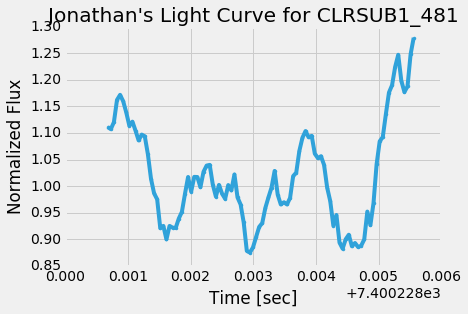

In [24]:
x = nircam_master_df['time']
y = nircam_master_df['aperture phot 3.0']
plt.plot(x, y/np.median(y), '.-')
plt.xlabel('Time [sec]')
plt.ylabel('Normalized Flux')
plt.title('Jonathan\'s Light Curve for wlp8sub_481')
print 'standard deviation = %f' % (np.std(y/np.median(y)))

Generate Scatter Matrix to Cross Compare All Values with Eachother
---

The scatter matrix is a pandas data frame function that plots every column of the data frame against every other column of the data frame in a matrix format.

The diagonal is a kernel density estimator (default: histogram) as a metric on the specific column distribution.

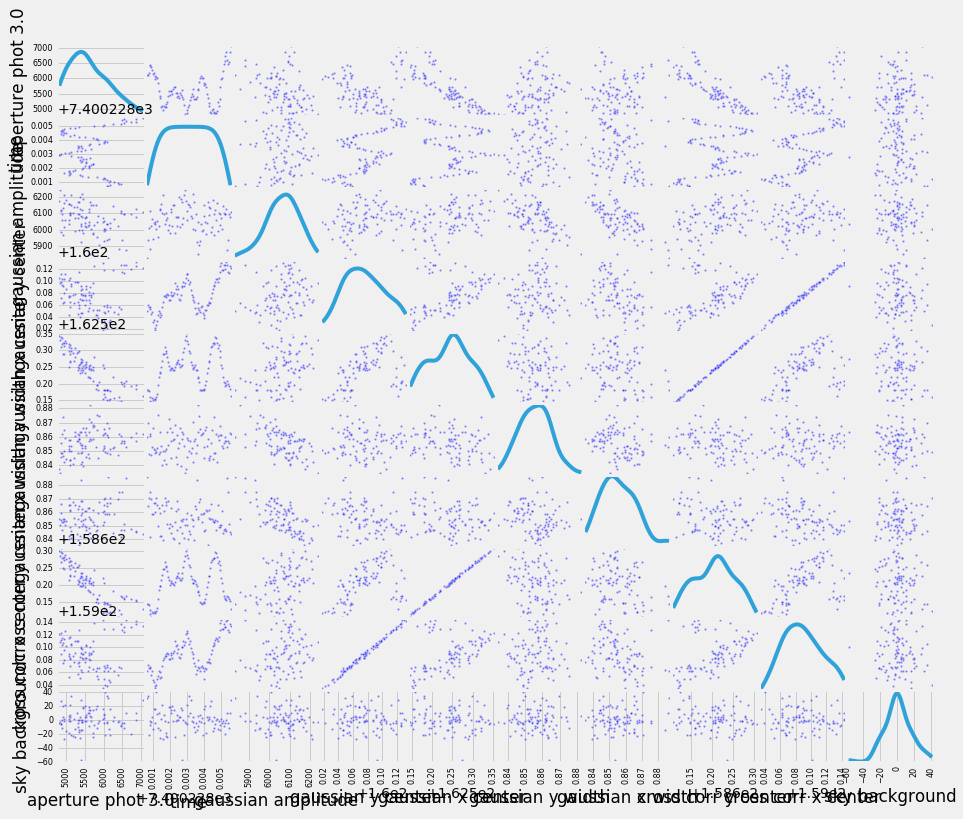

In [20]:
scatter_matrix(nircam_master_df.drop('filename',1), diagonal='kde', figsize=(14,12));

Plot All Values as Function of Time and Gaussian Centers
---

Cycle through all columns that have numerical data and plot them against time.

For special cases, plot the gaussian X and Y centers vs aperture photometry values

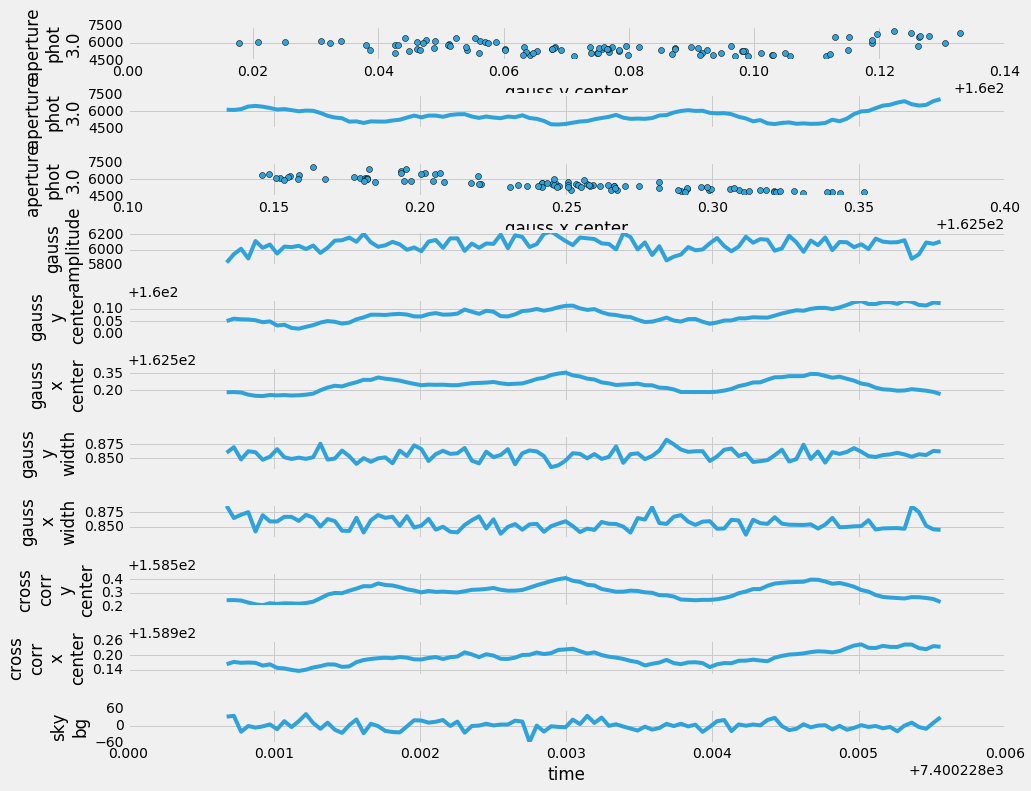

In [22]:
def renorm(arr):
    if arr.dtype == 'float64':
        return arr - median(arr)
    else:
        return arr

nircam_master_df.apply(renorm, axis=0)

fig = figure(figsize=(14,12))
for k, key in enumerate(nircam_master_df.keys()):
    ax  = fig.add_subplot(len(nircam_master_df.keys()), 1, k+1)
    if not key in ['time', 'filename']:
        ax.plot(nircam_master_df['time'], nircam_master_df[key])
        if k == len(nircam_master_df.keys()) - 1:
            ax.set_xlabel('time')
        else:
            ax.set_xticklabels([])
        
        ax.set_ylabel(key.replace('gaussian', 'gauss').replace('background', 'bg').replace(' ', '\n'))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

ax  = fig.add_subplot(len(nircam_master_df.keys()), 1, 1)
ax.plot(nircam_master_df['gaussian y center'], nircam_master_df['aperture phot 3.0'], 'o')
ax.set_ylabel('aperture phot 3.0'.replace(' ', '\n'))
ax.set_xlabel('gauss y center')
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

ax  = fig.add_subplot(len(nircam_master_df.keys()), 1, 3)
ax.plot(nircam_master_df['gaussian x center'], nircam_master_df['aperture phot 3.0'], 'o')
ax.set_ylabel('aperture phot 3.0'.replace(' ', '\n'))
ax.set_xlabel('gauss x center')
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

subplots_adjust( hspace=1 )
fig.canvas.draw()

---
The Following is Strictly from My Python Routine 
===
---

This routine is for later plotting with html interface. It is not useful for the above routines yet.

```python
import numpy as np
from bokeh.plotting import figure, show, output_file

N = 10000

x = np.random.normal(0,np.pi, N)
y = np.sin(x) + np.random.normal(0,0.2,N)

output_file('test_bokeh2.html', title='scatter 10k points')

p = figure(webgl=False)
p.scatter(x,y,alpha=0.1)
show(p)
```